## POOL BPT_WETH


Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

In [3]:
# set rendering mode 'notebook' for interactive view, 'svg' for export
pio.renderers.default = "svg"

In [4]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [5]:
EXPERIMENT_ID = 72

X_NAME = 'BPT'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [6]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [7]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [8]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [9]:
def find_longest_blocked_sequence(s: pd.Series):
    cnt = 0
    max_cnt = 0
    
    for index, value in s.items():
        if value != 'SUCCESS':
            cnt += 1
        else:
            max_cnt = max(max_cnt, cnt)
            cnt = 0
    
    return max(max_cnt, cnt)

In [10]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [11]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,BPT,WETH,0.028860,0.0,5.882351,0.023529,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,70.0,2020-05-31 20:25:38,2020-05-31 20:25:35,0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,1,0.020000,10.00000,0.200000,0,0,False,0.048860,4.094120,0.200039,0,0,False,83.792879,-0.832414
1,2,WETH,BPT,0.100000,0.0,0.001154,0.000400,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,107.0,2020-05-31 20:34:53,2020-05-31 20:34:44,0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x19bc2718782f2ae9d22c66d4d364394ecad1a771,2,0.048860,4.09412,0.200039,0,0,False,0.047706,4.193720,0.200067,46505,6,False,87.906846,0.049097
2,3,WETH,BPT,0.050000,0.0,0.000557,0.000200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,121.0,2020-05-31 20:38:23,2020-05-31 20:38:21,0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x19bc2718782f2ae9d22c66d4d364394ecad1a771,3,0.047706,4.19372,0.200067,46505,6,False,0.047150,4.243520,0.200081,64965,9,False,90.000649,0.023818
3,4,WETH,BPT,1.000000,0.0,0.008919,0.004000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,223.0,2020-05-31 21:03:53,2020-05-31 21:03:51,0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6,4,0.047150,4.24352,0.200081,64965,9,False,0.038231,5.239520,0.200311,202666,26,False,137.049836,0.522765
4,7,BPT,WETH,0.010674,0.0,0.212282,0.000849,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,31426.0,2020-06-06 07:04:38,2020-06-06 07:04:33,0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...,0x693c188e40f760ecf00d2946ef45260b84fbc43e,0x693c188e40f760ecf00d2946ef45260b84fbc43e,7,0.001878,0.25000,0.000469,202666,26,False,0.012551,0.036869,0.000463,62524871,3541,False,2.937537,-0.977939


In [12]:
swaps0_df

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,BPT,WETH,0.028860,0.0,5.882351,0.023529,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,70.0,2020-05-31 20:25:38,2020-05-31 20:25:35,0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,1,0.020000,10.000000,0.200000,0,0,False,0.048860,4.094120,0.200039,0,0,False,8.379288e+01,-0.832414
1,2,WETH,BPT,0.100000,0.0,0.001154,0.000400,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,107.0,2020-05-31 20:34:53,2020-05-31 20:34:44,0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x19bc2718782f2ae9d22c66d4d364394ecad1a771,2,0.048860,4.094120,0.200039,0,0,False,0.047706,4.193720,0.200067,46505,6,False,8.790685e+01,0.049097
2,3,WETH,BPT,0.050000,0.0,0.000557,0.000200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,121.0,2020-05-31 20:38:23,2020-05-31 20:38:21,0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x19bc2718782f2ae9d22c66d4d364394ecad1a771,3,0.047706,4.193720,0.200067,46505,6,False,0.047150,4.243520,0.200081,64965,9,False,9.000065e+01,0.023818
3,4,WETH,BPT,1.000000,0.0,0.008919,0.004000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,223.0,2020-05-31 21:03:53,2020-05-31 21:03:51,0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6,4,0.047150,4.243520,0.200081,64965,9,False,0.038231,5.239520,0.200311,202666,26,False,1.370498e+02,0.522765
4,7,BPT,WETH,0.010674,0.0,0.212282,0.000849,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,31426.0,2020-06-06 07:04:38,2020-06-06 07:04:33,0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...,0x693c188e40f760ecf00d2946ef45260b84fbc43e,0x693c188e40f760ecf00d2946ef45260b84fbc43e,7,0.001878,0.250000,0.000469,202666,26,False,0.012551,0.036869,0.000463,62524871,3541,False,2.937537e+00,-0.977939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,3210,WETH,BPT,0.003000,0.0,57303.735772,0.000012,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2587373.0,2021-08-24 00:51:23,2021-08-24 00:51:09,0x957b4936e85036ee20263b4e92fb47a5d92ce636e665...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xce6e51ae6a876feb78df6bd7ce224935d249d61f,3210,645399.679933,0.030480,19672.087329,72219724,301903797911063,False,588095.944161,0.033468,19682.673056,72219724,308336732158873,False,5.690989e-08,0.205021
3151,3211,WETH,BPT,0.004000,0.0,62221.612866,0.000016,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2587406.0,2021-08-24 00:59:38,2021-08-24 00:59:34,0x434eae879295625399358b088daffab5e28fe426ce3b...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xce6e51ae6a876feb78df6bd7ce224935d249d61f,3211,588095.944161,0.033468,19682.673056,72219724,308336732158873,False,525874.331295,0.037452,19695.294040,72219724,308345430120531,False,7.121943e-08,0.251442
3152,3212,WETH,BPT,0.005000,0.0,61389.767478,0.000020,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2587517.0,2021-08-24 01:27:23,2021-08-24 01:27:16,0x6810a641f416cb9ad102ac82a73ad3c375e02f75e137...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xce6e51ae6a876feb78df6bd7ce224935d249d61f,3212,525874.331295,0.037452,19695.294040,72219724,308345430120531,False,464484.563817,0.042432,19709.228577,72219724,308368808570560,False,9.135389e-08,0.282710
3153,3213,BPT,WETH,308326.263648,0.0,0.016827,0.000067,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,2589754.0,2021-08-24 10:46:38,2021-08-24 10:46:30,0xfeb0ca3b8abb121c3abeecd2729b46a38ed4d972af87...

In [13]:
swaps0_df.status.value_counts()

SUCCESS    3155
Name: status, dtype: int64

In [14]:
swaps1_df.status.value_counts()

SUCCESS                             2572
BLOCKED_BY_VOLATILITY_MITIGATION     564
NOT_ENOUGH_RESERVES                   19
Name: status, dtype: int64

In [15]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.17876386687797147


In [16]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                3109
CANT_CONSULT_ORACLE      27
NOT_REACHED              19
Name: mitigator_check_status, dtype: int64

In [17]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.00855784469096672


In [18]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    17
CLIPPED     1
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    17
CLIPPED     1
Name: status, dtype: int64


**564 out of 3155** have been **blocked by the volatility mitigation mechanism**. Only in about **0.008%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle

### Table of transactions blocked by Volatility Mitigation Mechanism

In [19]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp']]

,token_in,token_out,token_in_amount,token_out_amount,slice_factor,oracle_amount_out,out_amount_diff,reserve_Y_before,reserve_Y_before,transaction_timestamp
3,WETH,BPT,1.000000,0.008919,24.0,1.133431e-02,23.0,4.243520,4.243520,2020-05-31 21:03:51
10,WETH,BPT,0.455837,0.061999,30.0,1.269305e-01,68.0,1.514248,1.514248,2020-06-06 10:09:59
11,WETH,BPT,0.457138,0.062136,30.0,1.257433e-01,67.0,1.514248,1.514248,2020-06-06 10:16:32
14,BPT,WETH,0.065503,0.413138,30.0,3.142570e-01,27.0,1.834631,1.834631,2020-06-06 11:45:30
33,WETH,BPT,1.091553,0.130359,78.0,3.035843e-01,79.0,1.388671,1.388671,2020-06-07 10:11:19
36,BPT,WETH,0.097473,0.258415,28.0,3.774729e-01,37.0,1.190039,1.190039,2020-06-07 10:27:31
38,WETH,BPT,0.457573,0.115039,43.0,1.330030e-01,14.0,1.070600,1.070600,2020-06-07 13:11:56
39,BPT,WETH,0.108756,0.233063,28.0,3.945760e-01,51.0,1.070600,1.070600,2020-06-07 13:11:58
66,WETH,BPT,0.622761,0.118170,52.0,1.722104e-01,37.0,1.202194,1.202194,2020-06-07 23:28:02
67,BPT,WETH,0.080566,0.223850,23.0,3.115121e-01,32.0,1.202194,1.202194,2020-06-07 23:28:09


Text(0.5, 1.0, 'slice_factor Histogram (blocked transactions)')

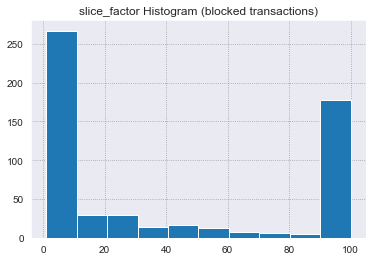

In [20]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('slice_factor Histogram (blocked transactions)')

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

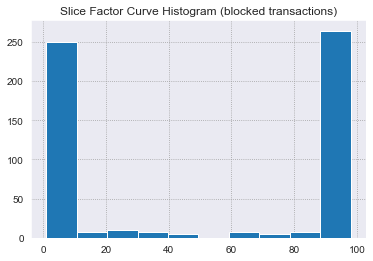

In [21]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

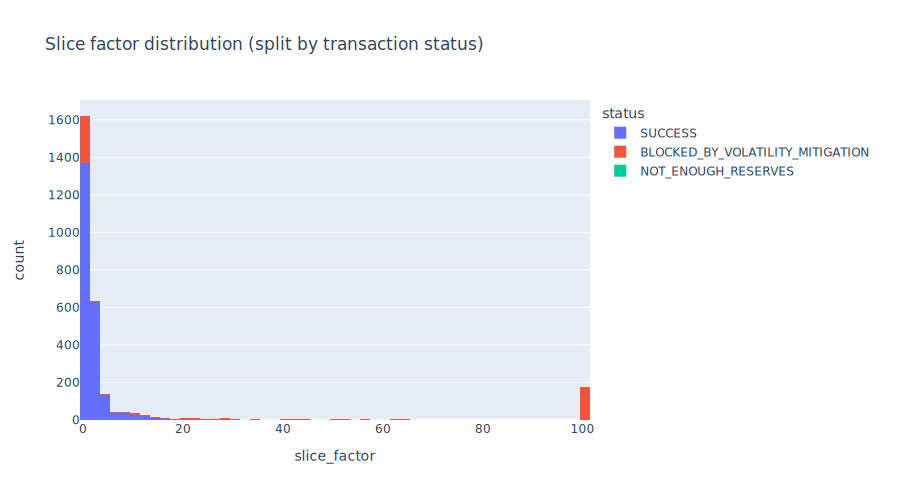

In [22]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="slice_factor", color="status",
                  title='Slice factor distribution (split by transaction status)', width=900, height=500).update_xaxes(categoryorder='total descending')
fig.show()

Note: in the plot above are not included the transactions for which TWAP COUDN'T BE COMPUTED and which weren't checked therefore by volatility mitigation mechanism

It can be observed that there is a high number of blocked transactions, with a slice_factor near
zero, which is not typical for an usual pool. The reason for this strange pattern is described
below

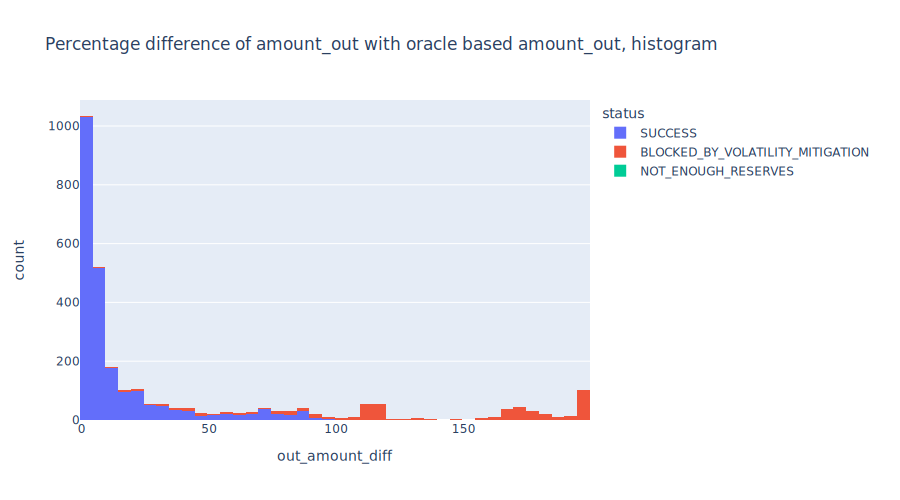

In [23]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram', width=900, height=500).update_xaxes(categoryorder='total descending')
fig.show()

The distribution of out_amount_diff indicates that there is a huge number of blocked transactions
with a price difference from the oracle one by more than 100%.


Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

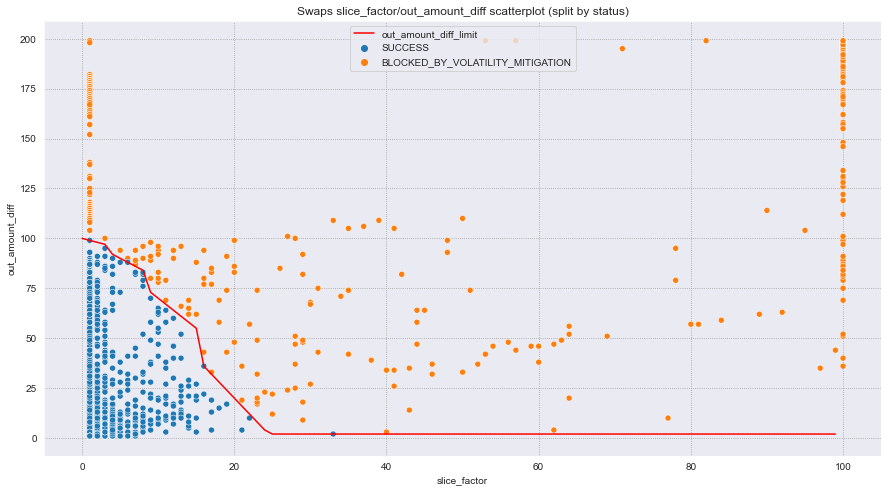

In [21]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The successful and blocked transactions are dispersed and not separated clearly by the
out_amount_diff_limit, as in the previous cases.


Text(0, 0.5, 'Count')

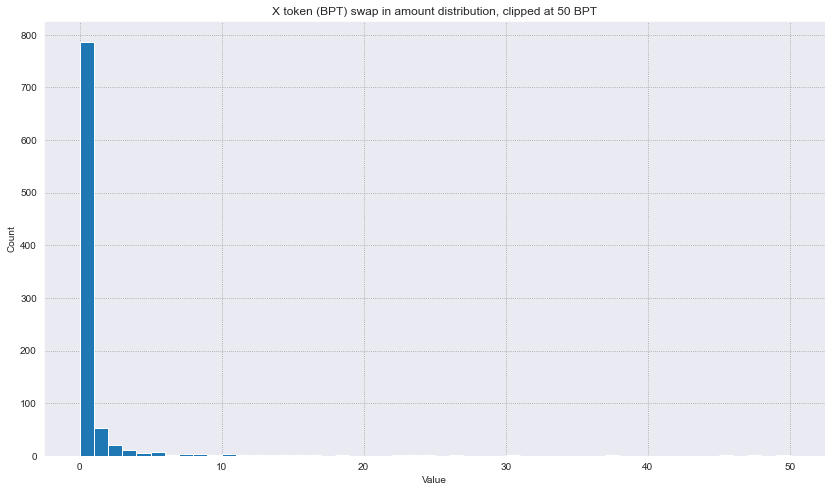

In [22]:
UPPER_LIMIT = 50


fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
#amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

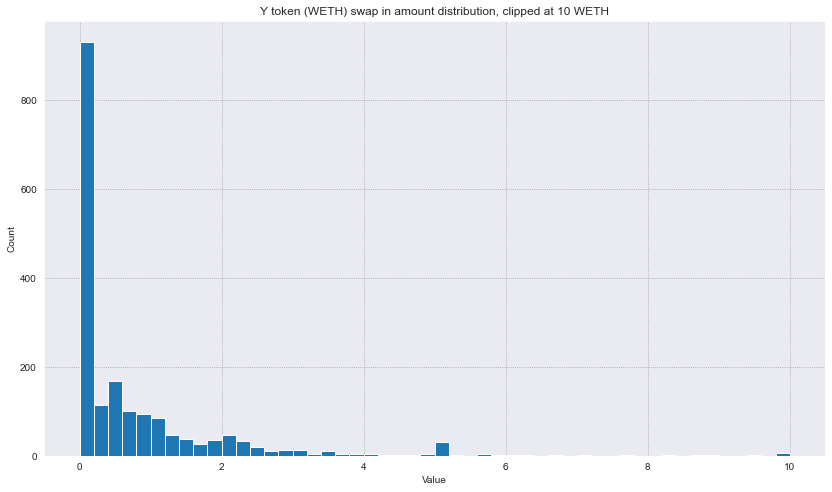

In [23]:
UPPER_LIMIT = 10

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

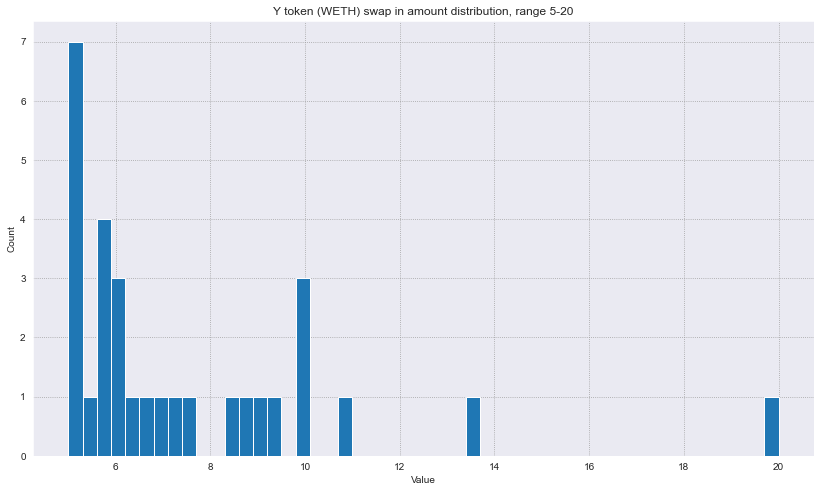

In [24]:
LOWER_LIMIT = 5
UPPER_LIMIT = 20
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

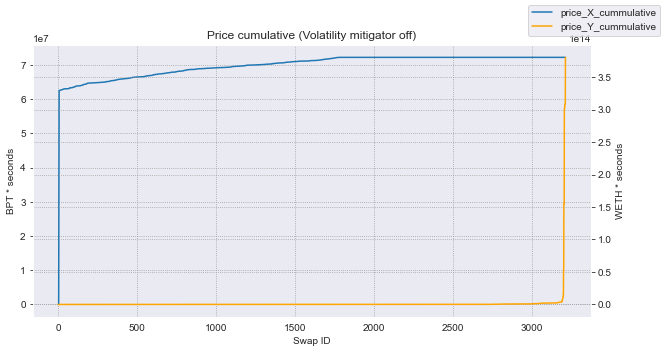

In [25]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

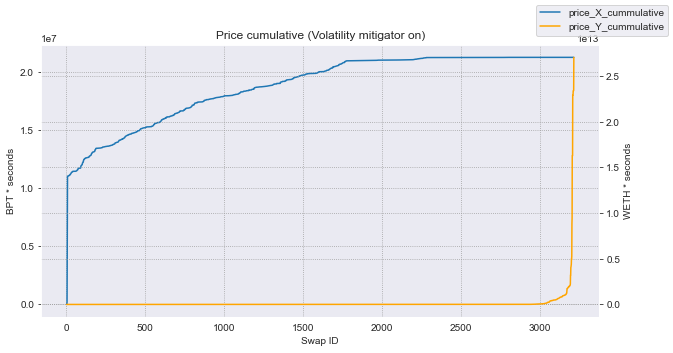

In [26]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

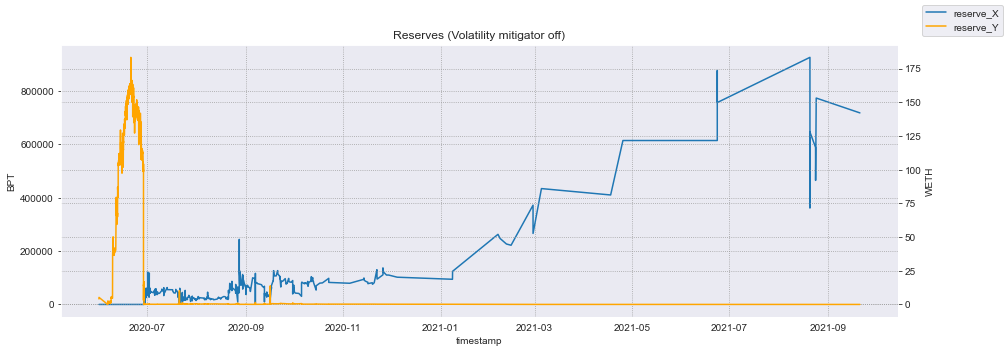

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

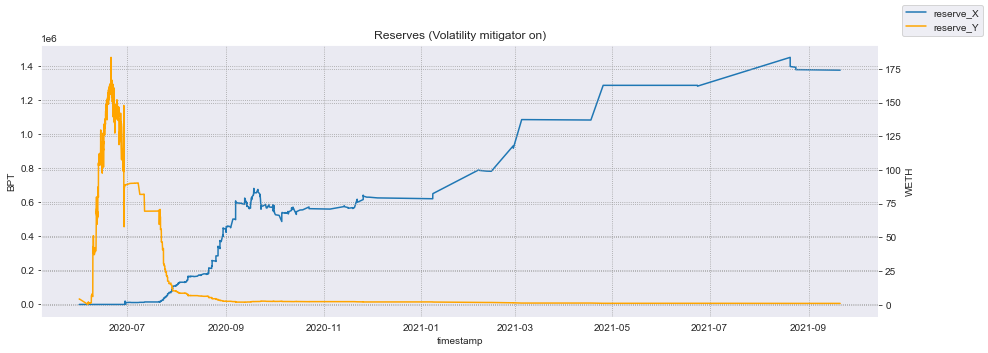

In [74]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

With the volatility mitigation mechanism disabled, it can be seen that all of the reserves of
WETH are depleted all at once. The volatility mitigation mechanism allowed sustaining the
reserves at relatively high levels for several months more, after a sudden ~50% drop

(18433.042372685184, 18444.042372685184)

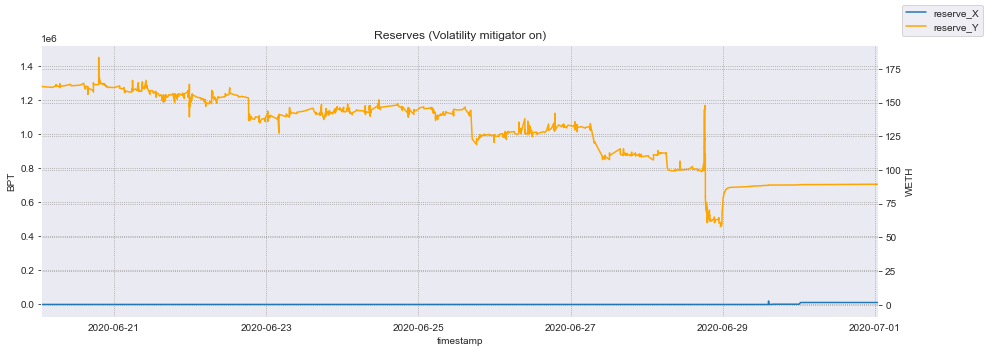

In [84]:
import datetime
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, 1, 1, 1, 1))
# ax2.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, , 1, 1, 1))

(18439.50070601852, 18473.042372685184)

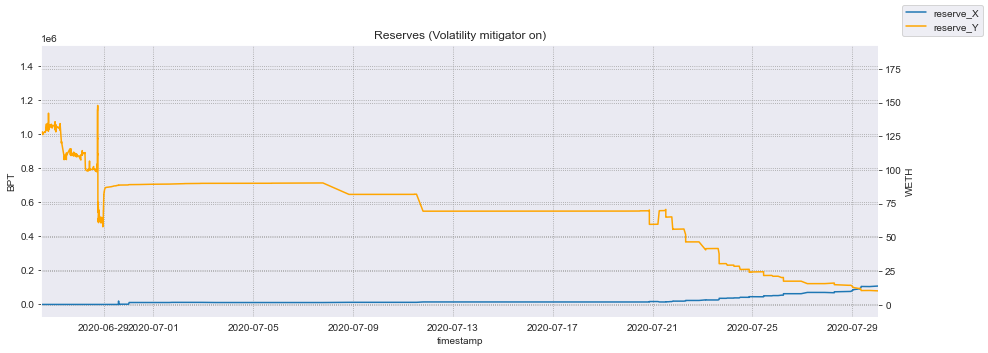

In [95]:
import datetime
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 26, 12,1,1), datetime.datetime(2020, 7, 30, 1, 1, 1))
# ax2.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, , 1, 1, 1))

(18438.50070601852, 18445.12570601852)

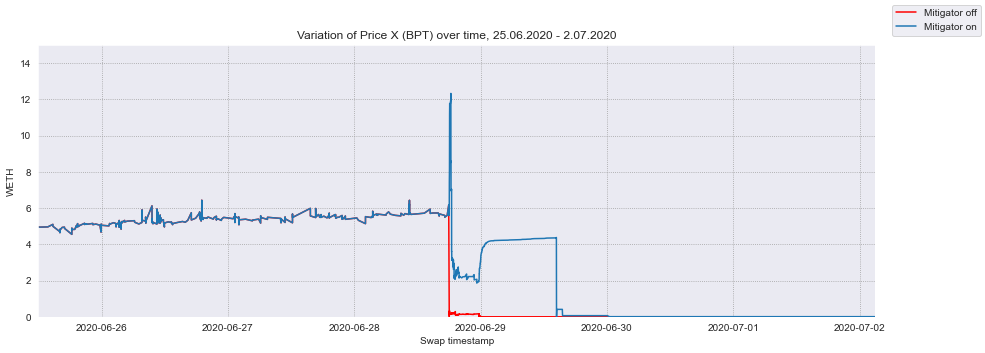

In [25]:
import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time, 25.06.2020 - 2.07.2020')
ax.set_ylim(0, 15)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 25, 12,1,1), datetime.datetime(2020, 7, 2, 3, 1, 1))


(18433.042372685184, 18444.042372685184)

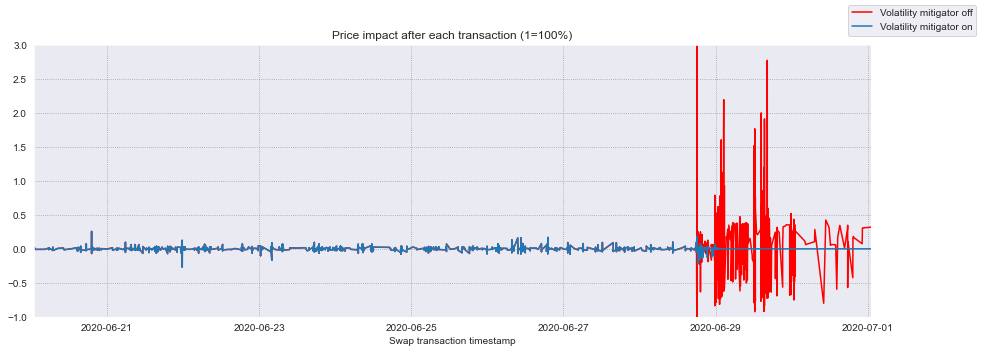

In [90]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, 1, 1, 1, 1))

In [37]:
find_longest_blocked_sequence(swaps1_df.status)

290

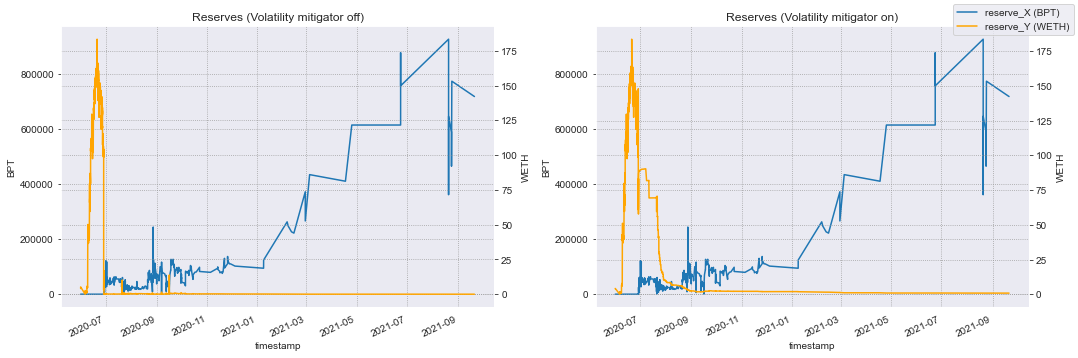

In [107]:

fig, ax = plt.subplots(1, 2,figsize=(15, 5))

ax2 = ax[0].twinx()

ax[0].plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label=f'reserve_X ({X_NAME})')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label=f'reserve_Y ({Y_NAME})', color='orange')

ax[0].set_xlabel('timestamp')
ax[0].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[0].set_title('Reserves (Volatility mitigator off)')

ax2 = ax[1].twinx()


ax[1].plot(swaps1_df.transaction_timestamp, swaps0_df.reserve_X, )
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, color='orange')

ax[1].set_xlabel('timestamp')
ax[1].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[1].set_title('Reserves (Volatility mitigator on)')

fig.autofmt_xdate(rotation=25)

fig.legend()
fig.tight_layout()


**It can be seen that after a series of big transactions BPT_ETH that significantly decreased the price of BPT, all of the subsequent transaction (in both directions) become blocked for more than 6 hours. As a result, there is a chain of 290 consecutively blocked transactions happening in 6+ hours**

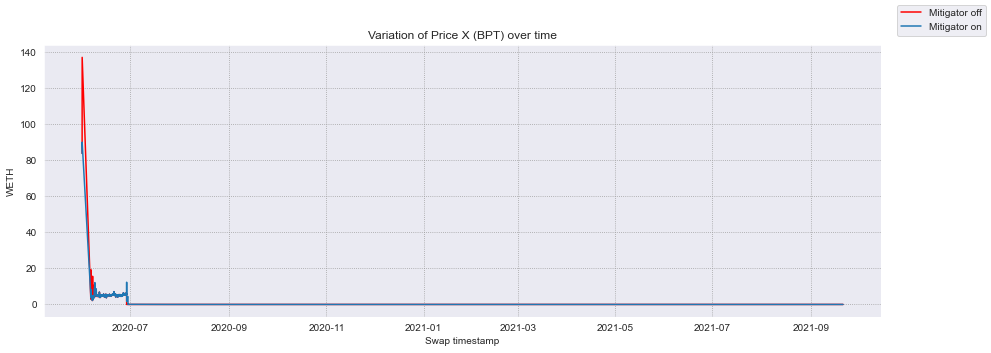

In [103]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 15)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

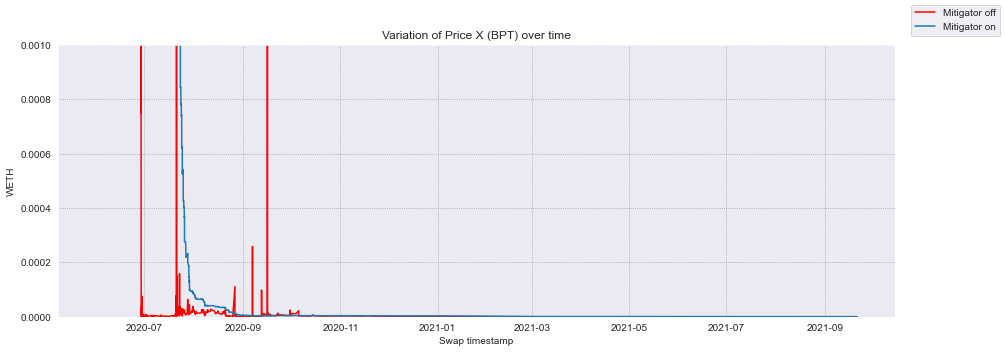

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 0.001)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**It can be seen that with the volatility mitigation mechanism enabled the price decreases much more smoothly, there are no sudden drops and increases**

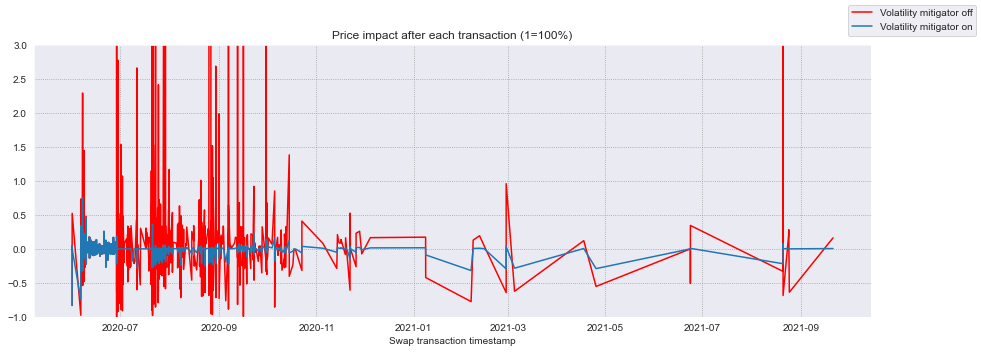

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

(18413.851099537038, 18890.832071759258)

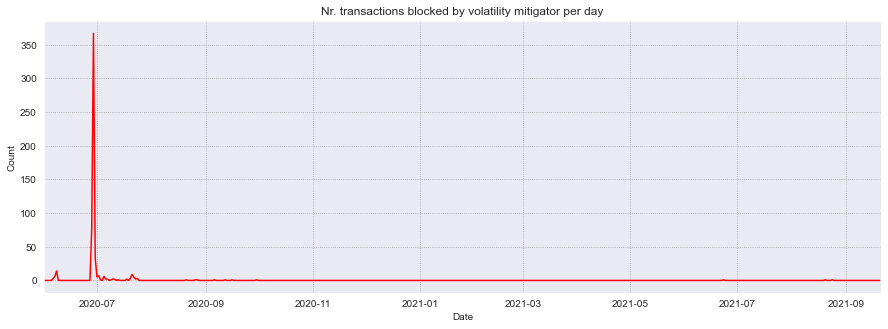

In [113]:
swaps1_indexed_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].copy()
swaps1_indexed_df.index = swaps1_indexed_df.transaction_timestamp
swaps1_indexed_df.loc[swaps1_df.transaction_timestamp.min()] = np.nan
swaps1_indexed_df.loc[swaps1_df.transaction_timestamp.max()] = np.nan
resampled24 = swaps1_indexed_df.resample('24h').size()
resampled24[0] -= 1
resampled24[-1] -= 1
resampled24.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled24.index, y=resampled24.values, linestyle='solid', color='red', marker=None,)

ax.set_title("Nr. transactions blocked by volatility mitigator per day")
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_xlim(swaps1_df.transaction_timestamp.min(), swaps1_df.transaction_timestamp.max())

**Most of the blocks happened during a single day**

In [27]:
swaps1_df[swaps1_df.price_diff > 0.4]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
32,36,WETH,BPT,0.342230,0.0,0.096318,0.001369,CHECKED,0.093709,2.0,33.0,98.0,SUCCESS,37496.0,2020-06-07 08:22:08,2020-06-07 08:21:58,0x323a2edacd4059df333220ad234e01043ddb401deb47...,0x40a7cb7052c274cc2e568c324b4c5d94383bec4f,0x40a7cb7052c274cc2e568c324b4c5d94383bec4f,36,0.394193,1.04781,0.413040,11395842,44662,True,0.297876,1.388671,0.413651,11400587,45333,True,4.661917,0.753844
122,133,WETH,BPT,8.701943,0.0,1.275335,0.034808,CHECKED,1.216827,4.0,21.0,84.0,SUCCESS,51086.0,2020-06-09 16:59:38,2020-06-09 16:59:27,0xb4b178ac07862f7c1af81f717403dd8384410ebd35d0...,0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66,0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66,133,7.364016,41.12922,302.876251,12651060,86185,True,6.088682,49.796355,303.194151,12651395,86196,True,8.178512,0.464329


Both 2 successful transactions with a price impact greater than 50% were not blocked as the TWAP coudn't be obtained from the oracle because of the missing observations